In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from py_func import ftest_p_cdf, ttest

### Data Retrieval

In [2]:
# Read Harris County crime count data and save as "crime_ct_df"
crime_ct_df =pd.read_csv("../data/cleandata/Harris_County_Crime_Ct_by_zipcode.csv")

# Preview "crime_ct_df"
crime_ct_df.head()

,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct
0,77002,148,32,29.756845,-95.365652,180
1,77003,54,7,29.749778,-95.345885,61
2,77004,131,42,29.724893,-95.363752,173
3,77005,30,1,29.718435,-95.423555,31
4,77006,131,16,29.740970,-95.391301,147


In [3]:
# Read Harris County crime count data and save as "crime_ct_df"
prop_value_df =pd.read_csv("../data/rawdata/Property_data.csv", encoding="ISO-8859-1")

# Preview "crime_ct_df"
prop_value_df.head()

,zip,address,lat,lng,house area,lot area,high,low,estimate,month value change,property tax
0,77004,"3327 FRANCIS ST, HOUSTON, TX 77004",29.728969,-95.354886,792.0,5001.0,100859,84504,90864,87.0,72000.0
1,77004,"1820 OAKDALE ST, HOUSTON, TX 77004",29.723462,-95.381033,2892.0,5500.0,635167,531231,577425,1263.0,383698.0
2,77004,"2220 MACGREGOR WAY, HOUSTON, TX 77004",29.715995,-95.380015,2813.0,8638.0,526769,425281,483274,7871.0,275131.0
3,77004,"2402 WENTWORTH ST, HOUSTON, TX 77004",29.724232,-95.373084,2748.0,6599.0,445146,316883,377242,-1526.0,182314.0
4,77004,"2424 ISABELLA ST, HOUSTON, TX 77004",29.729207,-95.368853,1470.0,5776.0,267123,241683,254403,1862.0,183358.0


In [4]:
# Calculate average property value of each zipcode
prop_value_zip_avg_df = pd.DataFrame(prop_value_df.groupby(["zip"])["estimate"].mean()).reset_index()

# Preview "prop_value_zip_avg_df"
prop_value_zip_avg_df.head()

,zip,estimate
0,77003,304618.520
1,77004,332700.348
2,77005,1185270.596
3,77006,642616.528
4,77007,528380.128


In [5]:
# Rename "zip" column as "ZIP"
prop_value_zip_avg_df = prop_value_zip_avg_df.rename(
    columns={"zip": "ZIP"
            })

# Preview "prop_value_zip_avg_df"
prop_value_zip_avg_df.head()

,ZIP,estimate
0,77003,304618.520
1,77004,332700.348
2,77005,1185270.596
3,77006,642616.528
4,77007,528380.128


In [6]:
len(crime_ct_df)

101

In [7]:
len(prop_value_zip_avg_df)

131

### Data Processing

In [8]:
# Merge crime data with property value
prop_and_crime = crime_ct_df.merge(prop_value_zip_avg_df, on="ZIP", how="left")

# Preview "prop_and_crime"
prop_and_crime.head()

,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,estimate
0,77002,148,32,29.756845,-95.365652,180,NaN
1,77003,54,7,29.749778,-95.345885,61,304618.520
2,77004,131,42,29.724893,-95.363752,173,332700.348
3,77005,30,1,29.718435,-95.423555,31,1185270.596
4,77006,131,16,29.740970,-95.391301,147,642616.528


In [9]:
# Sort the data by "estimate" in descending order
prop_and_crime = prop_and_crime.sort_values("estimate", ascending=False).reset_index(drop=True)

prop_and_crime = prop_and_crime.reset_index()

# Preview "prop_and_crime_sorted"
prop_and_crime.head()

,index,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,estimate
0,0,77019,103,5,29.754150,-95.409498,108,1337546.668
1,1,77024,103,6,29.772179,-95.514203,109,1311313.400
2,2,77005,30,1,29.718435,-95.423555,31,1185270.596
3,3,77056,129,7,29.748202,-95.468948,136,1144477.220
4,4,77027,82,3,29.740079,-95.446409,85,1077188.354


In [10]:
# Drop n/a data
prop_and_crime = prop_and_crime.dropna(how="any")

# Preview "prop_and_crime_sorted"
prop_and_crime.head()

,index,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,estimate
0,0,77019,103,5,29.754150,-95.409498,108,1337546.668
1,1,77024,103,6,29.772179,-95.514203,109,1311313.400
2,2,77005,30,1,29.718435,-95.423555,31,1185270.596
3,3,77056,129,7,29.748202,-95.468948,136,1144477.220
4,4,77027,82,3,29.740079,-95.446409,85,1077188.354


In [11]:
# Write "prop_and_crime" to csv file
prop_and_crime.to_csv("../data/cleandata/Harris_County_Crime_Ct_and_Prop_Value.csv", index=False, header=True)

### Data Analysis

##### Crime Counts with High and Low House Prices

In [12]:
# Add "High Est" and "Low Est" to "prop_and_crime"
prop_and_crime["High Est"] = ""
prop_and_crime["Low Est"] = ""

In [13]:
# Save values in "estimate" to "High Est" and "Low Est" columns
# Write NaN for columns without data to facilitate following manipulation
prop_and_crime.loc[prop_and_crime.estimate >= prop_and_crime.estimate.mean(), "High Est"] = prop_and_crime.loc[prop_and_crime.estimate >= prop_and_crime.estimate.mean(), "estimate"]
prop_and_crime.loc[prop_and_crime.estimate >= prop_and_crime.estimate.mean(), "Low Est"] = np.nan  

prop_and_crime.loc[prop_and_crime.estimate < prop_and_crime.estimate.mean(), "Low Est"] = prop_and_crime.loc[prop_and_crime.estimate < prop_and_crime.estimate.mean(), "estimate"]
prop_and_crime.loc[prop_and_crime.estimate < prop_and_crime.estimate.mean(), "High Est"] = np.nan      

# Preview "prop_and_crime"
prop_and_crime.head()

,index,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,estimate,High Est,Low Est
0,0,77019,103,5,29.754150,-95.409498,108,1337546.668,1.33755e+06,NaN
1,1,77024,103,6,29.772179,-95.514203,109,1311313.400,1.31131e+06,NaN
2,2,77005,30,1,29.718435,-95.423555,31,1185270.596,1.18527e+06,NaN
3,3,77056,129,7,29.748202,-95.468948,136,1144477.220,1.14448e+06,NaN
4,4,77027,82,3,29.740079,-95.446409,85,1077188.354,1.07719e+06,NaN


In [14]:
# Get dataframe for high estimate value 
high_est_and_crime = prop_and_crime.drop(["estimate", "Low Est"], axis=1).dropna(how="any")

# Preview "high_est_and_crime"
high_est_and_crime.head()

,index,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,High Est
0,0,77019,103,5,29.754150,-95.409498,108,1.33755e+06
1,1,77024,103,6,29.772179,-95.514203,109,1.31131e+06
2,2,77005,30,1,29.718435,-95.423555,31,1.18527e+06
3,3,77056,129,7,29.748202,-95.468948,136,1.14448e+06
4,4,77027,82,3,29.740079,-95.446409,85,1.07719e+06


In [15]:
# Get dataframe for low estimate value 
low_est_and_crime = prop_and_crime.drop(["estimate", "High Est"], axis=1).dropna(how="any")

# Preview "high_est_and_crime"
low_est_and_crime.head()

,index,ZIP,Non-Violet Ct,Violet Ct,LAT,LNG,Total Ct,Low Est
27,27,77003,54,7,29.749778,-95.345885,61,304619
28,28,77043,45,15,29.810930,-95.584639,60,299762
29,29,77069,2,2,29.988455,-95.531200,4,297914
30,30,77080,62,21,29.815894,-95.522885,83,290979
31,31,77336,4,3,30.063168,-95.098858,7,281376


In [16]:
# Check if the variances of non-violet crime counts in high and low estimate groups are equal
non_violet_by_est_ftest = ftest_p_cdf(high_est_and_crime["Non-Violet Ct"], low_est_and_crime["Non-Violet Ct"])

# Show the result of ftest
non_violet_by_est_ftest

False

In [17]:
# Check if non-violet crime counts in high and low estimate groups are different under the given ftest result
non_violet_by_est_ttest = ttest(high_est_and_crime["Non-Violet Ct"], low_est_and_crime["Non-Violet Ct"], non_violet_by_est_ftest)

# Show the result of test
if non_violet_by_est_ttest:
    print("The non-violet crime counts between low and high estimates group are statistically different!")
else:
    print("The non-violet crime counts between low and high estimates group are not different!")

The non-violet crime counts between low and high estimates group are statistically different!


In [18]:
# Check if the variances of violet crime counts in high and low estimate groups are equal
violet_by_est_ftest = ftest_p_cdf(high_est_and_crime["Violet Ct"], low_est_and_crime["Violet Ct"])

# Show the result of ftest
violet_by_est_ftest

False

In [19]:
# Check if violet crime counts in high and low estimate groups are different under the given ftest result
violet_by_est_ttest = ttest(high_est_and_crime["Violet Ct"], low_est_and_crime["Violet Ct"], violet_by_est_ftest)

# Show the result of test
if violet_by_est_ttest:
    print("The violet crime counts between low and high estimates group are statistically different!")
else:
    print("The violet crime counts between low and high estimates group are not different!")

The violet crime counts between low and high estimates group are not different!


In [20]:
non_violet_bargraph = [low_est_and_crime["Non-Violet Ct"].mean(), high_est_and_crime["Non-Violet Ct"].mean()]

non_violet_err = [low_est_and_crime["Non-Violet Ct"].sem(), high_est_and_crime["Non-Violet Ct"].sem()]

x_axis = np.arange(len(non_violet_bargraph))

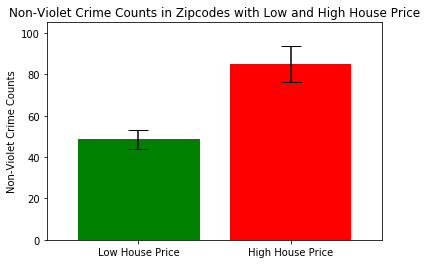

In [21]:
bar = plt.bar(x_axis, non_violet_bargraph, yerr=non_violet_err, capsize=10, color='r', align='center')
bar[0].set_color('g')

x = [value for value in x_axis]
plt.xticks(x, ["Low House Price", "High House Price"])
plt.ylim(0, max(non_violet_bargraph) + 20)
plt.xlim(-0.6, 1.6)
plt.title("Non-Violet Crime Counts in Zipcodes with Low and High House Price")
plt.ylabel("Non-Violet Crime Counts")

# Save figure
plt.savefig("../data/cleandata/Non-Violet Crime Ct (Low vs High House Price).png", dpi=300)


In [22]:
violet_bargraph = [low_est_and_crime["Violet Ct"].mean(), high_est_and_crime["Violet Ct"].mean()]

violet_err = [low_est_and_crime["Violet Ct"].sem(), high_est_and_crime["Violet Ct"].sem()]

x_axis = np.arange(len(violet_bargraph))

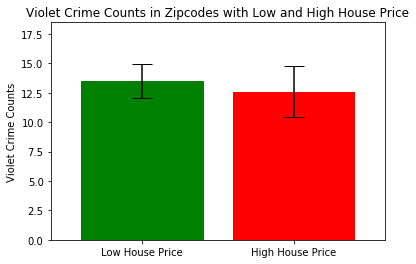

In [23]:
bar = plt.bar(x_axis, violet_bargraph, yerr=violet_err, capsize=10, color='r', align='center')
bar[0].set_color('g')

x = [value for value in x_axis]
plt.xticks(x, ["Low House Price", "High House Price"])
plt.ylim(0, max(violet_bargraph) + 5)
plt.xlim(-0.6, 1.6)
plt.title("Violet Crime Counts in Zipcodes with Low and High House Price")
plt.ylabel("Violet Crime Counts")

# Save figure
plt.savefig("../data/cleandata/Violet Crime Ct (Low vs High House Price).png", dpi=300)

##### Correlation between Crime Counts and House Prices

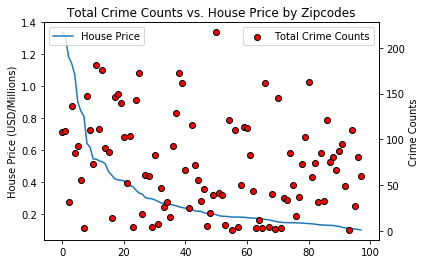

In [24]:
fig, ax1 = plt.subplots()
ax1.plot(prop_and_crime["index"], (prop_and_crime["estimate"] / 1000000), label="House Price")
ax1.set_ylabel("House Price (USD/Millions)")
ax1.legend(loc=2)
ax2=ax1.twinx()
ax2.scatter(prop_and_crime["index"], prop_and_crime["Total Ct"], facecolors='red', edgecolors='black', label="Total Crime Counts")
ax2.set_ylabel("Crime Counts")
ax2.legend(loc=1)

plt.title("Total Crime Counts vs. House Price by Zipcodes")

# Save figure
plt.savefig("../data/cleandata/Total Crime Counts vs. House Price.png", dpi=300)

In [25]:
correlation=prop_and_crime['estimate'].corr(prop_and_crime["Total Ct"])
print(correlation)
covariance = np.cov(prop_and_crime['estimate'], prop_and_crime["Total Ct"])
print(covariance)
correlation2 = pearsonr(prop_and_crime['estimate'], prop_and_crime["Total Ct"])
print(correlation2)
correlation3 = spearmanr(prop_and_crime['estimate'], prop_and_crime["Total Ct"])
print(correlation3)

0.20127516610039978
[[7.11225287e+10 2.80326021e+06]
 [2.80326021e+06 2.72733979e+03]]
(0.2012751661003997, 0.04688412179508718)
SpearmanrResult(correlation=0.20799352357027262, pvalue=0.039864926577994196)
